In [1]:
%cd '/home/naodell/work/wbr/analysis'

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scripts.plot_tools as pt

/home/naodell/work/wbr/analysis


In [2]:
selection = 'mumu'

# get the amc@nlo DY sample
datasets = [d for ds in ['zjets', 'zjets_alt', 'muon'] for d in pt.dataset_dict[ds]] #+ ['ttbar_lep']

dm = pt.DataManager(input_dir     = f'local_data/flatuples/z_cr/{selection}_2016',
                    dataset_names = datasets,
                    selection     = selection,
                    period        = 2016,
                    scale         = 35.9e3,
                    cuts          = '',
                    combine       = False
                   )

Loading dataframes: 100%|███████████████| 19.0/19.0 [00:27<00:00, 1.43s/it]


KeyError: 'data'

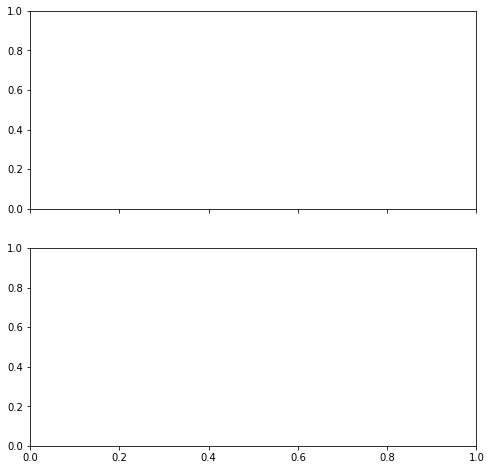

In [30]:
fig, axes = plt.subplots(2, 1, figsize=(8, 8), facecolor='white', sharex=True)

df_mg = dm.get_dataframe('zjets')
df_data = dm.get_dataframe('data')
feature = 'n_jets'

ax = axes[0]
bins = np.arange(-0.5, 5.5, 1.)
h_data, _, _ = ax.hist(df_data, bins=bins, range=xrange, color='C0', linewidth=2, histtype='step')
#h_nlo, b, _ = ax.hist(df_mg[feature], bins=bins, range=xrange, color='C0', linewidth=2, histtype='step', weights=df_mg.weight)
h_mg, _, _ = ax.hist(df_mg[feature], bins=bins, color='C1', linewidth=2, histtype='step', weights=df_mg.weight)

ax.set_xlim(bins[0], bins[-1])
ax.set_ylabel('Entries/2 GeV')
ax.legend(['AMC@NLO', 'MADGRAPH'])

ax = axes[1]
ax.plot(bins[:-1], h_data/h_mg, drawstyle='steps-post')
#ax.set_xlabel(r'lead muon $p_{T}$')
ax.set_ylabel('AMC@NLO / MADGRAPH')
ax.grid()

plt.tight_layout()
plt.show()